# 単語分散表現

本章では、最初に異なるテキストどうしの類似度（近さ）をはかる方法について説明します。単純な BoW （文書単語行列）から紹介し、
次に「意味を考慮して形態素をデータ化する方法」と、これを活用してテキストの類似度を調べる方法を説明します。


## 文書ベクトル

まずベクトルという概念を説明します。

たとえば以下では A と Bという2つのリストを用意しています。それぞれの要素は整数ですが、これらがベクトルにあたります。

In [1]:
import numpy as np
A = np.array([7,3])
B = np.array([3,7])
print(A)
print(B)

[7 3]
[3 7]


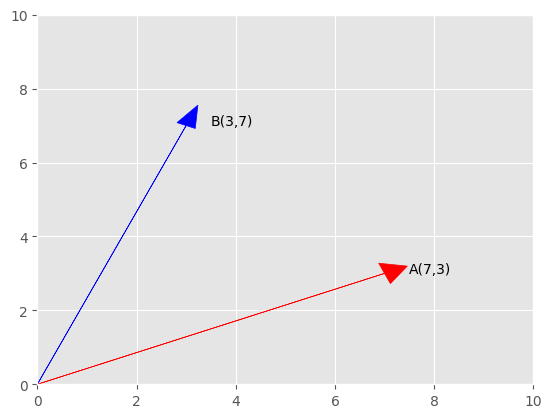

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
ax = plt.axes()
ax.arrow(0.0, 0.0, A[0], A[1], head_width=0.6, head_length=0.5, color = 'red')
plt.annotate(f'A({A[0]},{A[1]})', xy=(A[0], A[1]), xytext=(A[0]+0.5, A[1]))
ax.arrow(0.0, 0.0, B[0], B[1], head_width=0.4, head_length=0.6, color = 'blue')
plt.annotate(f'B({B[0]},{B[1]})', xy=(B[0], B[1]), xytext=(B[0]+0.5, B[1]))
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

## コサイン類似度

このとき、2つの矢印はそれぞれベクトルを表しています。２つベクトルの近さは、それぞれの矢印の間のコサインで表すことができます。


$$
\frac{7 \times 3 + 3 \times 7 } { \sqrt{ 7^2 + 3^2} \times \sqrt{3^2 + 7^2}} = 0.7241379
$$


もっとも、毎回この計算を行うのは大変です。そこで scikit-learn の **cosine_similarity** を使ってみます。



In [3]:
print(A)
## A の次元数
print(A.ndim)

[7 3]
1


In [4]:
## 次元を変換
print(A.reshape(1, -1).ndim)

2


In [5]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim = cosine_similarity(A.reshape(1, -1), B.reshape(1, -1))
print (f'コサイン類似度:{cos_sim}')

コサイン類似度:[[0.72413793]]


In [6]:
A = np.array([7, 3, 1, 6, 8])
B = np.array([3, 7, 2, 1, 0])
cos_sim = cosine_similarity(A.reshape(1, -1), B.reshape(1, -1))
print (f'コサイン類似度:{cos_sim}')

コサイン類似度:[[0.49957554]]


## テキストの類似度

ところで、文書単語行列では、テキストごとに出現した単語の頻度をベクトルとして表現し、これらを並べて行列として結合したものだと考えることができます。
この場合、各文書の次元（ベクトルの要素数）は、すべての文書を通じて出現した語彙数ということになります。



ここでも歴代総理大臣所信表明演説データを利用しましょう。



In [7]:
## data/utf8フォルダにあるファイル一覧を取得
import os
import re
files = ['data/utf8/' + path for path in os.listdir('data/utf8')]
pattern = 'data/utf8/\\d{8}_(\\d{1,3}_[a-z]{1,}-[a-z]{1,})_general-policy-speech.txt'
results = [re.match(pattern, file_name) for file_name in files]
prime_names = [ res.group(1) for res in results]
stopwords = [],
with open('data/stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = [w.strip() for w in f]
## ストップワードをさらに追加
stopwords.extend(['あの', 'この', 'ある', 'する', 'いる', 'できる', 'なる', 'れる', 'の', 'は', '〇', 'ソ', 'もつ', 'わが国', 'われわれ','私たち','そのため','行なう','おこなう','%'])
## セットに変更（形態素が重複して登録されているのを避けるため）
stopwords = set(stopwords)
## ストップワードの要素数を確認
len(stopwords)
## 単語文書行列の作成
from sklearn.feature_extraction.text import CountVectorizer
import my_mecab_stopwords as my_tokenizer
args={'stopwords_list': stopwords}
vectorizer = CountVectorizer(input='filename', lowercase=False,
                             max_df=0.5, max_features=300,
                             tokenizer=lambda text: my_tokenizer.tokens(text, **args))
prime_dtm = vectorizer.fit_transform(files)
## 文書単語行列のサイズを確認
print(prime_dtm.shape)

(82, 300)



テキスト分析では、文書の長さを合わせることは必ずしも簡単ではありません。そこで、文書の長さに合わせて頻度を調整することを考えます。それが先の章で紹介した TF-IDF ということになります。

In [8]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
## 各ドキュメントのTF-IDFを計算
tfidf = transformer.fit_transform(prime_dtm) 

In [10]:
import pandas as pd
df = pd.DataFrame(tfidf.todense(), columns = vectorizer.get_feature_names(), index = prime_names )
print(df)

                         あす      あわせる        いう      かかわる       つくる        とる  \
47_sato-eisaku          0.0  0.075430  0.000000  0.000000  0.000000  0.038310   
185_abe-shinzo          0.0  0.135286  0.032800  0.000000  0.152379  0.000000   
26_kishi-nobusuke       0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
163_koizumi-jyunichiro  0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
49_sato-eisaku          0.0  0.052303  0.000000  0.000000  0.188516  0.053128   
...                     ...       ...       ...       ...       ...       ...   
81_fukuda-takeo         0.0  0.000000  0.063526  0.065504  0.000000  0.000000   
127_hosokawa-morihiro   0.0  0.000000  0.000000  0.000000  0.000000  0.082194   
119_kaifu-toshiki       0.0  0.031005  0.060136  0.031005  0.027937  0.062987   
149_mori-yoshiro        0.0  0.000000  0.015882  0.016377  0.029514  0.000000   
150_mori-yoshiro        0.0  0.000000  0.019097  0.000000  0.053230  0.000000   

                           

/mnt/2bddf92b-47f9-4809-95a5-b91e7f25af27/myData/GitHub/myPython/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


この文書単語行列の特徴は、文書ごとに長さが1に正規化されていることです。ここで **正規化** とは、各文書の要素をそれぞれ自乗して合計した値の平方根を取ると、1 になっているということです。検算してみましょう。ちなみに、平方根をとるというのは、0.5 乗するということです。

In [11]:
print(df.apply(lambda x: (x**2).sum()** 0.5, axis=1))

47_sato-eisaku            1.0
185_abe-shinzo            1.0
26_kishi-nobusuke         1.0
163_koizumi-jyunichiro    1.0
49_sato-eisaku            1.0
                         ... 
81_fukuda-takeo           1.0
127_hosokawa-morihiro     1.0
119_kaifu-toshiki         1.0
149_mori-yoshiro          1.0
150_mori-yoshiro          1.0
Length: 82, dtype: float64



確かに正規化されています。所信表明演説のすべてのペアについて類似度を測ります。これは簡単です。
文章単語行列全体に `cosine_similarity()` を適用するだけです。

In [12]:
prime_sim = cosine_similarity(df)
prime_sim

array([[1.        , 0.09230969, 0.20314657, ..., 0.19133002, 0.08584242,
        0.15251584],
       [0.09230969, 1.        , 0.02794921, ..., 0.23785236, 0.15298248,
        0.2556736 ],
       [0.20314657, 0.02794921, 1.        , ..., 0.02109276, 0.03230471,
        0.10520748],
       ...,
       [0.19133002, 0.23785236, 0.02109276, ..., 1.        , 0.1656268 ,
        0.27399853],
       [0.08584242, 0.15298248, 0.03230471, ..., 0.1656268 , 1.        ,
        0.69726534],
       [0.15251584, 0.2556736 , 0.10520748, ..., 0.27399853, 0.69726534,
        1.        ]])

例えば1行目の出力の見方は、0番目の所信表明演説(47_sato-eisaku) と 0 番目の所信表明演説の類似度は 1 ということです。つまり、完全に一致しているということになります。これは当然ですね。その横にある 0.30063538 は0番目の所信表明演説と1番目の所信表明演説(185_abe-shinzo)の類似度です。

各行ごとに最大値、つまりもっとも類似している所信表明演説を確認してみましょう。なお、各行の最大値は 1 になっています。これは、自分自身との類似度を求めているので、当然です。
ちなみに、自分自身との類似度は行列の対角要素になります。

In [13]:
## 行列の対角成分を出力する
np.diag(prime_sim)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

単純に各行の最大値を求めてしまうと、自分自身との類似度1が選ばれてしまいます。そこで、この対角要素を `np.fill_diagonal()` で0 に変えてから、最大値を求めることにします。
3行3列の行列を例に、この作業のイメージを示しましょう。

In [14]:
## 単純な行列を作成し
A = np.array([[1,2,3], [4,5,6], [7,8,9]])
print(A)
print('行列の対角成分を0に変える')
np.fill_diagonal(A, 0)
print(A)

[[1 2 3]
 [4 5 6]
 [7 8 9]]
行列の対角成分を0に変える
[[0 2 3]
 [4 0 6]
 [7 8 0]]


では、文書単語行列の対角成分を0に置き換えてしまいます。

In [15]:
np.fill_diagonal(prime_sim, 0)
prime_sim

array([[0.        , 0.09230969, 0.20314657, ..., 0.19133002, 0.08584242,
        0.15251584],
       [0.09230969, 0.        , 0.02794921, ..., 0.23785236, 0.15298248,
        0.2556736 ],
       [0.20314657, 0.02794921, 0.        , ..., 0.02109276, 0.03230471,
        0.10520748],
       ...,
       [0.19133002, 0.23785236, 0.02109276, ..., 0.        , 0.1656268 ,
        0.27399853],
       [0.08584242, 0.15298248, 0.03230471, ..., 0.1656268 , 0.        ,
        0.69726534],
       [0.15251584, 0.2556736 , 0.10520748, ..., 0.27399853, 0.69726534,
        0.        ]])

対角成分を確認してみましょう。1行目と1列目、また2行目と2列目の成分を表示してみます。

In [16]:
print(prime_sim[0][0])
print(prime_sim[1][1])

0.0
0.0


In [17]:
row_max_index = np.argmax(prime_sim, axis=1)
print(row_max_index)

[75 65 71 43 57 31 24 31 45 21 36 16 37 65 16 59 14 22 47 60 53  9 58 30
 75 41  9 31 68 48 23 75 71 62 24 49 10 77 37 16 65 25 65 17 38  8 49 53
 67 35 80  1 49 56 25 80 53  4 22 56 75 78 33 45 38 42 28 73 73 36  0 32
 60 67 61 31  9 37 61 11 55 80]


対角要素と、その右上の要素をすべて0に変えます。以下にこの作業のイメージを示します。

In [18]:
A = np.array([[0,2,3], [2,0,1], [3,1,0]])
print(A)
print('右上の要素をすべて0に変える')
A = np.tril(A)
print(A)

[[0 2 3]
 [2 0 1]
 [3 1 0]]
右上の要素をすべて0に変える
[[0 0 0]
 [2 0 0]
 [3 1 0]]


後の作業のため、ここで所信表明演説の類似度行列のコピーを作成し、このコピーを操作します。いったんデータフレームに変換します。

In [19]:
print(len(prime_sim))
prime_sim2 =  np.tril(prime_sim)
df2 = pd.DataFrame(columns=['X', 'Y', 'similarity'])

for i, j in enumerate(row_max_index):
    if prime_sim2[i][j] == 0:
        continue
    else:
        df2 = df2.append({'X': prime_names[i] , 'Y': prime_names[j], 'similarity': prime_sim2[i][j] }, ignore_index=True)
df2.sort_values('similarity', ascending=False).head(20)

82


/tmp/ipykernel_62015/95743228.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'X': prime_names[i] , 'Y': prime_names[j], 'similarity': prime_sim2[i][j] }, ignore_index=True)
/tmp/ipykernel_62015/95743228.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'X': prime_names[i] , 'Y': prime_names[j], 'similarity': prime_sim2[i][j] }, ignore_index=True)
/tmp/ipykernel_62015/95743228.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df2 = df2.append({'X': prime_names[i] , 'Y': prime_names[j], 'similarity': prime_sim2[i][j] }, ignore_index=True)
/tmp/ipykernel_62015/95743228.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use

,X,Y,similarity
16,57_sato-eisaku,62_sato-eisaku,0.848907
19,59_sato-eisaku,57_sato-eisaku,0.782025
23,178_noda-yoshihiko,179_noda-yoshihiko,0.772783
29,168_fukuda-yasuo,168_abe-shinzo,0.726031
36,149_mori-yoshiro,146_obuchi-keizo,0.722004
8,144_obuchi-keizo,143_obuchi-keizo,0.702743
37,150_mori-yoshiro,149_mori-yoshiro,0.697265
34,127_hosokawa-morihiro,128_hosokawa-morihiro,0.683462
11,88_ohira-masayoshi,90_ohira-masayoshi,0.666702
3,141_hashimoto-ryutaro,139_hashimoto-ryutaro,0.647692


ペアの類似度が高いのは、ほとんどが同じ総理大臣による（別の国会での別の）演説となっています。これは互いに内容が似ているのも当然でしょう。また、異なる総理大臣による所信表明演説が高い類似度を示している場合は、時代間隔（国会の開催年月日）がきわめて近いことも確認できます。



たとえば、安倍晋三氏は 168 期の国会で退陣し、その 5 年後に再び総理大臣に返り咲いています。つまり最初の就任期と、第183回との間には時間的なズレがあり、そのため演説の内容やスタンスも変わっていると思われます。確認してみましょう。最初に作成した `prime_sim` から検索します。 ただし、この配列には行名（また列名）がないので、いったんデータフレームに変換しましょう。この結果を `filter()` を使って絞り込みます。まず index に `abe` が含まれている行を抽出し、続けて列名に `abe` が含まれている列を探します。

In [20]:
df3 = pd.DataFrame(prime_sim, columns=prime_names, index=prime_names)
df3.filter(like = 'abe', axis=0).filter(regex='abe').sort_index()

,185_abe-shinzo,183_abe-shinzo,165_abe-shinzo,187_abe-shinzo,168_abe-shinzo
165_abe-shinzo,0.312261,0.382760,0.000000,0.361620,0.567292
168_abe-shinzo,0.280728,0.375282,0.567292,0.321299,0.000000
183_abe-shinzo,0.462252,0.000000,0.382760,0.443823,0.375282
185_abe-shinzo,0.000000,0.462252,0.312261,0.621897,0.280728
187_abe-shinzo,0.621897,0.443823,0.361620,0.000000,0.321299



出力が分かりにくいかと思いますが、例えば1行目 (165_abe-shinzo) は第165回国会での所信表明演説にあたり、その内容について第1列目(165_abe-shinzo)、すなわち第185回演説との近さを測ると約 32％となっています。一方、3列めの第165回演説との類似度は1ということです。つまり、完全に一致しているということになります。これは当然ですね。その横にある 0.51687549 は1番目の所信表明演説と2番目の所信表明演説(168_abe-shinzo )の類似度です。ちなみに安倍元総理は、この段階で退陣し、5年後に再び総理大臣に返り咲いています。つまり最初の就任期と、第183回との間には時間的なズレがあり、そのため演説の内容やスタンスも変わっていると思われます。実際、時間的に離れた所信表明演説の類似度は小さくなっているようです。

165 期と 168 期の演説の類似度は約 0.495 です。また 183 期以降の演説それぞれの類似度はそれぞれ 0.5 を超えています。が、165 期ないし 168 期の演説と、183 期以降の演説との類似度は 0.2 から 0.3 のあいだとなっています。

一方、181 期の旧民主党の野田元総理と 185 期の自民党安倍元総理の類似度が 0.67 と高いことに気が付きます。
参考までに文書単語行列に登録された単語の一覧をみてみましょう。


In [21]:
print(vectorizer.get_feature_names())

['あす', 'あわせる', 'いう', 'かかわる', 'つくる', 'とる', 'とれる', 'はかる', 'ふさわしい', 'めぐる', 'もたらす', 'よい', 'エネルギー', 'サミット', 'サービス', 'システム', 'テロ', '一体', '一端', '上げる', '上昇', '不可欠', '世代', '中央', '主要', '予定', '事件', '事実', '事態', '事故', '交換', '交流', '人口', '人材', '人間', '人類', '介護', '仕事', '会談', '住宅', '住民', '使命', '供給', '依存', '価値', '価格', '保険', '個人', '倫理', '働く', '先進', '克服', '全国', '公債', '公正', '共通', '内容', '内政', '円滑', '再建', '再生', '処理', '分権', '利用', '制', '削減', '前進', '割り', '創造', '力強い', '労働', '動き', '動向', '北朝鮮', '医療', '協議', '南北', '危機', '参加', '収支', '取りまとめる', '取り戻す', '取り組み', '受けとめる', '合う', '合意', '合理', '向かう', '含む', '含める', '国交', '国土', '国連', '土地', '地球', '均衡', '型', '基礎', '基調', '基軸', '堅持', '増加', '声', '変革', '外国', '多様', '大切', '大幅', '大胆', '大震災', '太平洋', '委員', '姿', '姿勢', '子供', '存じる', '学校', '安心', '家庭', '寄与', '対外', '対話', '導入', '展望', '展開', '市場', '幅広い', '平成', '年代', '年金', '年間', '引き続く', '形成', '役', '役割', '従来', '復旧', '復興', '徹底', '応じる', '思い', '急速', '情報', '意味', '憲法', '懸案', '戦略', '所存', '所得', '払う', '抜本', '担う', '拉致', '拡充', '挙げる', '提案', '支える', '支持', '改正', '政

/mnt/2bddf92b-47f9-4809-95a5-b91e7f25af27/myData/GitHub/myPython/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


安倍総理の演説における「復興」と「被災地」の出現確率を確認します。（「復興」あるいは「被災地」が、いずれのトピックでも上位語に含まれていない場合があります。その場合は、上の出力を参考に適宜、単語を変更してください）

In [23]:
#df.filter(like='abe', axis=0)[['復興', '被災地']]
df.filter(like='abe', axis=0)[['復興']]

,復興
185_abe-shinzo,0.141890
183_abe-shinzo,0.260913
165_abe-shinzo,0.061723
187_abe-shinzo,0.149475
168_abe-shinzo,0.043414


In [24]:
# df.filter(like='noda', axis=0)[['復興', '被災地']]
df.filter(like='noda', axis=0)[['復興']]

,復興
181_noda-yoshihiko,0.138565
179_noda-yoshihiko,0.344189
178_noda-yoshihiko,0.189230




## 単語分散表現

前章までは、テキストから BoW を作成していました。BoW をベースにしたモデルでは、文書ごとに形態素（単語）の出現回数を調べ、必要に応じて頻度を TF-IDF などに変換したデータを分析の出発点とします。
この場合、形態素が出現した位置、あるいは文脈（その形態素が、別のどのような形態素の後ないし前に出現したのか）は考慮されていません。

しかしながら、文章においては、形態素が文中のどこに出現しているかは非常に重要です。ある形態素がどの位置に出現するかは、まず文章全体によって決まります。つまり、出現位置は、文章の意味と深く関わっています。形態素の多くは特定の文脈に現れることから、同じような文脈に表れる形態素の意味は似ているとする仮説があります。たとえば以下の2つの文は、同じような文脈を表しています。

1. 校庭 で サッカー を した。
2. 校庭 で 野球 を した。

サッカーと野球は似て非なるもののですが、ボールを使う球技で人間が「する」ものであり、かつ校庭にような広いスペースを必要とするという共通点があります。
出現する文脈が似ている場合、その意味も似ていると考えるのが、**分布仮説** です。そこで、大量のテキストから、ある形態素がどのような文脈で出現したかを調べれば、分布の似ている形態素を知ることができます。そこで、ある形態素の意味を、近隣に出現しやすい形態素との近さとして表現できると便利です。



## Word2Vec

**単語分散表現** の嚆矢である Word2Vec では、大規模なテキスト集合であるコーパスから単語分散表現を作成します。
この際には主に2つの方法が使われています。
1つは、ある特定の文脈に出現しやすい単語を予測できるようなモデルを生成することです。
もう1つは、ある単語の周辺に出現しやすい単語群を予測できるようなモデルを生成することになります。
前者を CBOW, 後者を **skip-gram** と呼びます。 

いずれも方法でも、入力となるのは単語の **ワンホットベクトル** です。


### ワンホットベクトル

いま、出現する語が「犬」「猫」「猿」「雉」「人」の5つだけのテキストがあるとします。
このとき、「犬」を次のベクトルで表現します。このとき、それぞれの単語を次のベクトルで表現します。行列の列（縦）が各単語のベクトルになります。

| 犬 | 猫 | 猿 | 雉 | 人 | 
|---|---|---|--|---|
| 1 | 0 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 | 0 |
| 0 | 0 | 1 | 0 | 0 |
| 0 | 0 | 0 | 1 | 0 |
| 0 | 0 | 0 | 0 | 1 |

要は、行ごとにみると1行名が「犬要素」、2行目が「猫要素」、3行目が「猿要素」、4行目が「雉要素」、5行目が「人要素」に対応しているわけです。
そして1列目の犬は、5行のうち該当するのが1行目だけであり、ここを 1 とし、ほかがすべて0になります。
単純ですが、これにより各単語が 5 次元のベクトルで表され、互いに区別できるわけです。

ただし、読者の中には、猿と人は近いから、猿ベクトルと人ベクトルは、「猿要素」と「犬要素」の両方に反応しても良いのではないかと思う方も要るかもしれません。

| 犬 | 猫 | 猿 | 雉 | 人 | 
|---|---|---|--|---|
| 1 | 0 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 | 0 |
| 0 | 0 | 1 | 0 | 1 |
| 0 | 0 | 0 | 1 | 0 |
| 0 | 0 | 1 | 0 | 1 |

ただ、こうすると「猿」と「人」のベクトルがまったく同じなって区別がつきません。
そこで、たとえば次のようにして、「人」は「人要素」が強く、「猿要素」は弱いが、「猿」は逆であることを示す頃ができるかもしれません。


| 犬 | 猫 | 猿 | 雉 | 人 | 
|---|---|---|--|---|
| 1 | 0 | 0 | 0 | 0 |
| 0 | 1 | 0 | 0 | 0 |
| 0 | 0 | 0.8 | 0 | 0.1 |
| 0 | 0 | 0 | 1 | 0 |
| 0 | 0 | 0.2 | 0 | 0.9 |

単語を複数次元のベクトルで表すということは、このように単語と単語の違いに加えて、その近さ（類似度）を表現することでもあります。
上で猿ベクトルと人ベクトルの数値は適当に決めましたが、これらを大規模テキストデータを使って計算しようというのが、ここで紹介するワードベクトルになります。


### skip-gram

東北大学の乾・岡崎研究室 [^tohoku_uni] では、研究過程で作成した単語分散表現を公開しています。
以下、本書でも、このモデルを利用させてもらいます。

[^tohoku_uni]: <https://www.nlp.ecei.tohoku.ac.jp/> <http://www.cl.ecei.tohoku.ac.jp/~m-suzuki/jawiki_vector/>


ダウンロードした単語分散表現を扱うために Python に **gensim** ライブラリを導入します。

`pip install gensim`

準備が整いましたので、ダウンロードした単語分散表現を使ってみましょう。

なお、gensim は Anaconda には付属していません。別途 `pip` でインストールしてください。

In [25]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 6.3 MB/s eta 0:00:00m eta 0:00:010:00:01


In [26]:
import gensim
from gensim.models.word2vec import Word2Vec
## ダウンロードした単語分散表現が Jupyter を起動しているフォルダにあるとします
model = gensim.models.KeyedVectors.load_word2vec_format('entity_vector.model.bin', binary=True)

ここで利用するのモデルはファイル名の末尾が bin となっています
これを使って、「徳島」がここでどのように表現されているかを確認してみましょう。

In [27]:
print(model['徳島'])
model['徳島'].shape

[-0.1451146   0.64631635  1.1206466   0.53557366  1.1265059  -0.47855055
 -1.9572403  -0.36092016 -0.12230052  0.00528774 -0.9410112   0.5655498
 -0.34019628  0.03107905  1.2963295  -0.03178046  0.67060477  1.1305983
 -0.3368416  -1.2133294   1.1458337  -1.2171845   1.3975791  -0.8819545
  0.8784004  -1.0548002  -1.2283356   0.04045669 -0.01702263 -0.32386667
 -1.0599047   0.8248806   0.12551713 -0.12358826  2.4171948   0.5412358
  1.6744537   0.7213261  -0.07311266  1.221979    0.60591567  0.6359788
 -1.6467801  -0.483416    0.33695164  0.52571183 -0.8949706   0.6989222
  0.10594787  1.4380262   2.4102638  -1.5664365  -0.1476826  -1.0740054
  0.13817035  0.28903145  1.1353608   0.02972492  0.42153484  0.3525321
  0.41672072  0.45877242 -1.367437   -1.2573254   0.44229034  1.6489668
 -0.5580291   1.5877541   0.45503724  0.41794908 -0.48812628 -0.75694937
  0.16592807  0.21474564 -0.39681706  0.40212667 -0.72284573 -1.7669711
 -0.71841913 -0.3941651   1.3607436   1.4318576   0.43657574 

(200,)

In [28]:
model.most_similar('徳島県')

[('香川県', 0.8651489615440369),
 ('岡山県', 0.8528105616569519),
 ('山口県', 0.8483657240867615),
 ('愛媛県', 0.8469836711883545),
 ('高知県', 0.8455371856689453),
 ('熊本県', 0.8427625894546509),
 ('新潟県', 0.8358582258224487),
 ('島根県', 0.8284846544265747),
 ('鳥取県', 0.8260581493377686),
 ('静岡県', 0.8161298632621765)]

上位 5 つは、要するに中国・四国地方に位置する県になっています。他に、熊本や新潟が似ていると判断されています。

もう少し、単語分散表現で遊んでみましょう。単語分散表現で話題によく上がるのが、概念を計算できることです。「東京」から「日本」を引いて、「フランス」を足すという操作ができるのです。

`東京 - 日本 + フランス`



In [29]:
model.most_similar(positive=['東京', 'フランス'], negative=['日本'])

[('パリ', 0.7462971210479736),
 ('[パリ]', 0.6993756294250488),
 ('ベルリン', 0.6419284343719482),
 ('ロンドン', 0.6390188336372375),
 ('ミラノ', 0.6374871730804443),
 ('ウィーン', 0.6211003065109253),
 ('ブリュッセル', 0.6124843955039978),
 ('ミュンヘン', 0.6093114614486694),
 ('ハンブルク', 0.5993486642837524),
 ('[リヨン]', 0.5960404872894287)]



次に、「阿波おどり」から「徳島」を引いて、高知を足してみましょう。

`阿波おどり - 徳島 + 高知`


In [30]:
model.most_similar(positive=['阿波おどり', '高知'], negative=['徳島'])

[('[よさこい]', 0.6300591230392456),
 ('夏祭り', 0.5732635259628296),
 ('[よさこい祭り]', 0.5656487941741943),
 ('[YOSAKOI]', 0.5619512796401978),
 ('夏まつり', 0.5619202256202698),
 ('総踊り', 0.5596013069152832),
 ('夏祭', 0.5583030581474304),
 ('[阿波踊り]', 0.5561996102333069),
 ('おどり', 0.548295259475708),
 ('まつり', 0.5472521185874939)]

「よさこい」がもっともらしいと出ました。

In [31]:
import my_janome_stopwords as jnm
text1 = jnm.tokens('徳島で、阿波踊りを見学した')
print(text1)
text2 = jnm.tokens('青森で、ねぶた祭を観た')
print(text2)
text3 = jnm.tokens('福岡で、豚骨ラーメンを食べた')
print(text3)

['徳島', '阿波', '踊り', '見学', 'する']
['青森', 'ねぶた', '祭', '観る']
['福岡', '豚', '骨', 'ラーメン', '食べる']


それぞれの文章から抽出された形態素は、いずれもが 200 次元のベクトルで表現されています。


ある文章が3つの形態素からなっていたとします。この形態素をそれぞれ word1,word2,word3 とします。


In [32]:
import numpy as np
word1 = np.array([1,2,3,4,5])
word2 = np.array([5,4,3,2,1])
word3 = np.array([1,0,2,0,3])

In [33]:
words = word1 + word2 + word3
words / 3

array([2.33333333, 2.        , 2.66666667, 2.        , 3.        ])

つまり、この3語からなる文章を 5 次元のベクトルに表現することができました。

In [34]:
def avg_vec(word_list, model):
    ## 計算結果を蓄積する空のベクトルを用意しておく
    vec_ = np.zeros((200,), dtype='float32') 
    for word in word_list:
        vec_ = np.add(vec_, model[word])
    if len(word_list) > 0:
        vec_ = np.divide(vec_, len(word_list))
    return vec_

In [35]:
avg1 = avg_vec(text1, model)
avg2 = avg_vec(text2, model)
avg3 = avg_vec(text3, model)

前回と同じ方法でコサイン距離を求めます。

In [36]:
from sklearn.metrics.pairwise import cosine_similarity
cos_sim1 = cosine_similarity(avg1.reshape(1, -1), avg2.reshape(1, -1))
print (f'コサイン類似度: txt1 vs txt2 :{cos_sim1}')
cos_sim2 = cosine_similarity(avg1.reshape(1, -1), avg3.reshape(1, -1))
print (f'コサイン類似度: txt1 vs txt3 :{cos_sim2}')
cos_sim3 = cosine_similarity(avg2.reshape(1, -1), avg3.reshape(1, -1))
print (f'コサイン類似度: txt2 vs txt3 :{cos_sim3}')

コサイン類似度: txt1 vs txt2 :[[0.5231217]]
コサイン類似度: txt1 vs txt3 :[[0.46388638]]
コサイン類似度: txt2 vs txt3 :[[0.3673437]]


In [37]:
## スカイツリ - 日本 + フランス
model.most_similar(positive=['スカイツリー', 'フランス'], negative=['日本'])

[('[エッフェル塔]', 0.5456256866455078),
 ('マドリッド', 0.5358479022979736),
 ('[シャンゼリゼ通り]', 0.49942439794540405),
 ('[トラファルガー広場]', 0.49436208605766296),
 ('[リール_(フランス)]', 0.49335700273513794),
 ('ヴィラ', 0.4929209351539612),
 ('[エトワール凱旋門]', 0.49175509810447693),
 ('[パレ・ロワイヤル]', 0.49152642488479614),
 ('ナポリ', 0.49030327796936035),
 ('シャトー', 0.488348126411438)]

In [38]:
## ワイン - フランス + 日本 
model.most_similar(positive=['ワイン', '日本'], negative=['フランス'])

[('[日本茶]', 0.6305805444717407),
 ('[泡盛]', 0.6159665584564209),
 ('[日本酒]', 0.5956202149391174),
 ('[清酒]', 0.5938064455986023),
 ('焼酎', 0.5927814841270447),
 ('[焼酎]', 0.5906597375869751),
 ('清酒', 0.5873808860778809),
 ('地酒', 0.5791105031967163),
 ('日本酒', 0.5710263848304749),
 ('[納豆]', 0.5674401521682739)]



こうした単語分散表現は他にも公開されています。
「白ヤギコーポレーション」[^siroyagi] モデルは、やはり日本語ウィキペディアから学習されています。
[^siroyagi]: <https://aial.shiroyagi.co.jp/2017/02/japanese-word2vec-model-builder/>


In [ ]:
%%script false --no-raise-error
from gensim.models.word2vec import Word2Vec
model_path = 'word2vec.gensim.model'
model = Word2Vec.load(model_path)